# Tema 6: Grover

En este notebook vamos a implementar el algoritmo de Grover para diferentes oráculos.

El algoritmo de Grover es uno de los algoritmos cuánticos más importantes, ya que permite realizar búsquedas en bases de datos no estructuradas con una aceleración cuadrática respecto a los algoritmos clásicos. Mientras que un algoritmo clásico requiere $O(N)$ consultas para encontrar un elemento en una base de datos de $N$ elementos, el algoritmo de Grover lo consigue en $O(\sqrt{N})$ consultas.

El algoritmo funciona mediante la aplicación repetida de dos operaciones principales:
1. Un oráculo que marca el estado solución
2. Un operador de difusión (o amplificación de amplitud) que amplifica la probabilidad de medir el estado marcado

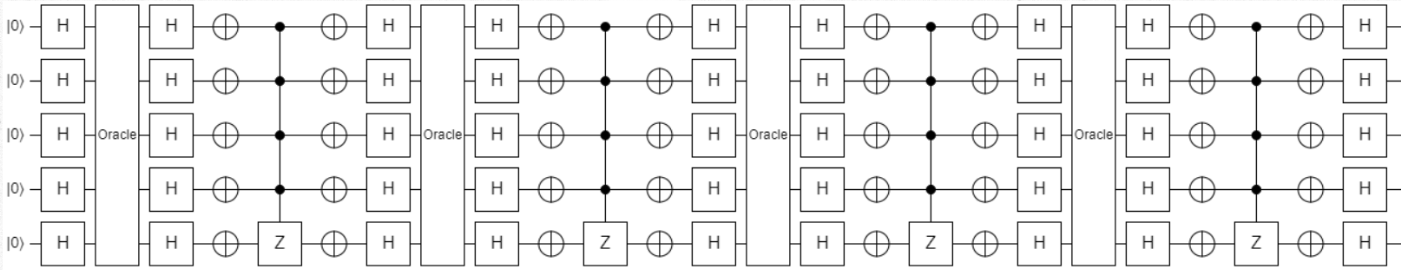

El algoritmo de Grover se basa en la aplicación iterativa de dos operadores principales:

**1. Oráculo (O):** Marca el estado solución aplicando un cambio de fase. Si |x⟩ es la solución, entonces:
$$O|x\rangle = -|x\rangle$$
Para cualquier otro estado |y⟩: $O|y\rangle = |y\rangle$

**2. Operador de difusión (D):** También conocido como operador de inversión sobre la media. Se define como:
$$D = 2|s\rangle\langle s| - I$$
donde $|s\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle$ es el estado de superposición uniforme.

**Número de iteraciones óptimo:**
Para una base de datos de N elementos, el número óptimo de iteraciones es:
$$r \approx \frac{\pi}{4}\sqrt{N}$$

**Probabilidad de éxito:**
Después de r iteraciones, la probabilidad de medir el estado correcto es:
$$P_{éxito} = \sin^2\left((2r+1)\theta\right)$$
donde $\theta = \arcsin\left(\frac{1}{\sqrt{N}}\right)$

**Complejidad:**
- Clásico: $O(N)$ consultas
- Grover: $O(\sqrt{N})$ consultas

Esto representa una aceleración cuadrática, que es óptima para búsqueda en bases de datos no estructuradas.

## Librerías

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCMTGate, ZGate
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits. Vamos a definirlo ya de forma abstracta con una función que reciba el número n y el oráculo como una instrucción.

**Operador de difusión (Grover Diffusion Operator):**

El operador de difusión se implementa mediante la secuencia: $D = H^{\otimes n} \cdot (2|0\rangle\langle 0| - I) \cdot H^{\otimes n}$

En la práctica, esto se descompone en los siguientes pasos:

1. **H en todos los qubits:** Transforma de la base computacional a la base de Hadamard
2. **X en todos los qubits:** Invierte todos los estados, convirtiendo $|0\rangle \leftrightarrow |1\rangle$
3. **Z multicontrolada:** Aplica una fase negativa $(-1)$ solo al estado $|11...1\rangle$. Debido a las puertas X anteriores, esto equivale a marcar el estado $|00...0\rangle$ original
4. **X en todos los qubits:** Revierte la inversión del paso 2
5. **H en todos los qubits:** Regresa a la base computacional original

Esta secuencia implementa efectivamente la **inversión sobre la media**: cada amplitud se refleja respecto al promedio de todas las amplitudes. Matemáticamente: $D|\psi\rangle = 2\langle\psi|\psi\rangle|\psi\rangle - |\psi\rangle$, donde $\langle\psi|\psi\rangle$ es la amplitud promedio.

In [1]:
def Grover_Circuit(n:int, oracle):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n))
    #Control-Z con varios ctrl
    multicontrolz = MCMTGate(ZGate(), n-1, 1)
    for i in range(n_reps):
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle'], reps=2)

    return decomp_qc

### Ejercicio

Prueba a hacer la misma función, pero usando el repeat.

In [6]:
def Grover_Circuit(n:int, oracle):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n))
    #Control-Z con varios ctrl
    multicontrolz = MCMTGate(ZGate(), n-1, 1)
    def repetition_step(n:int, oracle):
        qc = QuantumCircuit(3, name='Repetition')
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

        return qc

    qc.append(repetition_step(n, oracle).repeat(n_reps), range(n))

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle',"Repetition**2",'Repetition'], reps=3)

    return decomp_qc

## Oráculo

Ahora definamos un oráculo para introducir.  Vamos a probar uno que marque el estado 100.

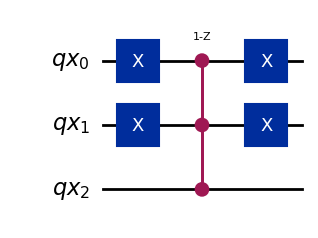

In [7]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMTGate(ZGate(), n-1, 1)
oracle.x(range(n-1))
oracle.append(multicontrolz, range(n))
oracle.x(range(n-1))

oracle.draw('mpl')

Convertimos el oráculo en una gate.

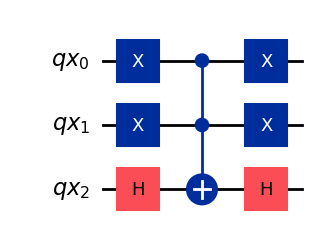

In [8]:
decomp_oracle = oracle.decompose('mcmt', reps=2)
decomp_oracle.draw('mpl')

In [9]:
oracle_gate = decomp_oracle.to_gate()

Creamos un circuito cuántico de esos n qubits.

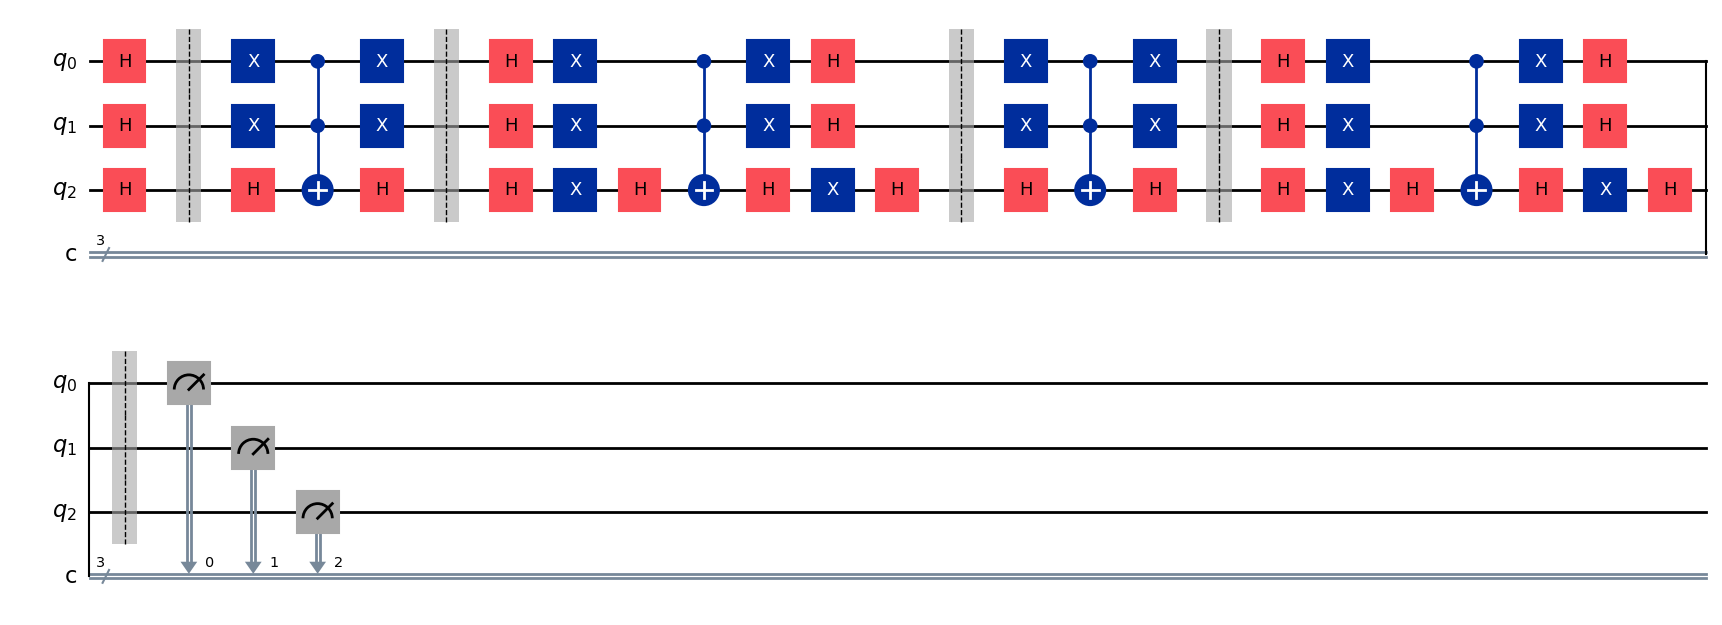

In [10]:
qc = Grover_Circuit(n, oracle_gate)

qc.draw('mpl')

---
# Ejecutando el circuito

Vamos a comprobar si obtenemos el resultado esperado. Deberíamos obtener el 100.

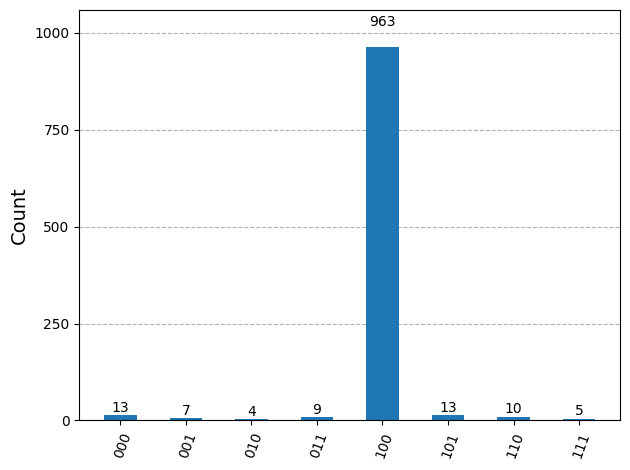

In [11]:
#Obtenemos el simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Obtenemos que todas las medidas son para el 100, por lo que es balanceada, como esperábamos.

Importante: fijaos en que los bits están al revés de cómo podríamos pensar al ver los circuitos. Si queréis que se vea como lo solemos pensar, llega con poner measure(range(n), range(n-1,-1,-1)) para que asigne al revés.

---
# Ejercicio con otro oráculo

Ahora haz un oráculo que marque otro estado y pruébalo.

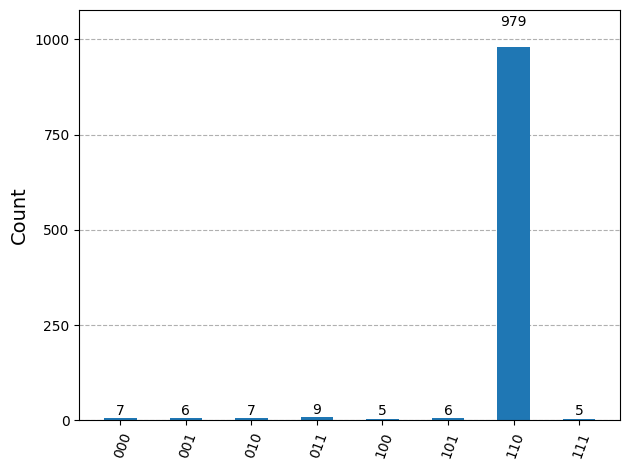

In [13]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMTGate(ZGate(), n-1, 1)
oracle.x(0)
oracle.append(multicontrolz, range(n))
oracle.x(0)

decomp_oracle = oracle.decompose('mcmt', reps=2)
oracle_gate = decomp_oracle.to_gate()

qc = Grover_Circuit(n, oracle_gate)

#Obtenemos el simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

---
# Ejercicio extra

Prueba a hacer un oráculo que marque más de un estado. En este caso, ten en cuenta que si se marcan t soluciones, hay que aplicar $\frac{\pi}{4}\sqrt{\frac{N}{t}}$ repeticiones. Deberás cambiar la función global.

In [14]:
def Grover_Circuit(n:int, oracle, t:int=1):
    #Registros
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')

    #Circuito
    qc = QuantumCircuit(qr, cr, name='Grover')

    #Capa de H
    qc.h(range(n))
    qc.barrier()

    n_reps = int(np.pi/4*np.sqrt(2**n / t))
    #Control-Z con varios ctrl
    multicontrolz = MCMTGate(ZGate(), n-1, 1)
    for i in range(n_reps):
        #Oraculo
        qc.append(oracle, range(n))
        qc.barrier()

        #Difusor
        qc.h(range(n))
        qc.x(range(n))
        qc.append(multicontrolz, range(n))
        qc.x(range(n))
        qc.h(range(n))
        qc.barrier()

    #Mediciones
    qc.measure(range(n), range(n))

    decomp_qc = qc.decompose(['mcmt', 'Oracle'], reps=2)

    return decomp_qc

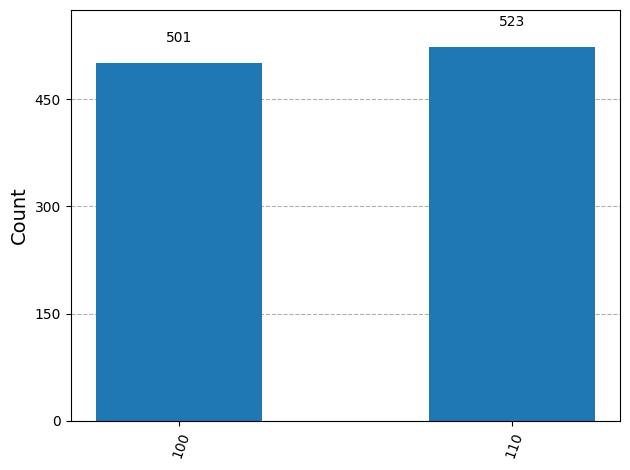

In [15]:
n = 3

#Registros
qr_x = QuantumRegister(n, 'qx')

oracle = QuantumCircuit(qr_x, name='Oracle')

#Puertas
multicontrolz = MCMTGate(ZGate(), n-2, 1)
oracle.x(0)
oracle.append(multicontrolz, [0,2])
oracle.x(0)

decomp_oracle = oracle.decompose('mcmt', reps=2)
oracle_gate = decomp_oracle.to_gate()

qc = Grover_Circuit(n, oracle_gate,t=2)

#Obtenemos el simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)